In [1]:
# we are allowed to use: python standard library and matplotlib nothing more
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, matplotlib.pyplot as plt

### urllib.request practice problems

In [2]:
from urllib.request import Request, urlopen, urlretrieve
from pathlib import Path

In [3]:
# Fetch the raw HTML of https://httpbin.org/html and save it to a local file named page.html.
# Make the file byte-for-byte identical to what the server sent (hint: watch encoding).
req = Request('https://httpbin.org/html')
with urlopen(req) as resp:
  data = resp.read()
  with open('page.html', 'wb') as f:
    f.write(data)

In [4]:
with open('page.html') as f:
  contents = f.read()
print(contents)

<!DOCTYPE html>
<html>
  <head>
  </head>
  <body>
      <h1>Herman Melville - Moby-Dick</h1>

      <div>
        <p>
          Availing himself of the mild, summer-cool weather that now reigned in these latitudes, and in preparation for the peculiarly active pursuits shortly to be anticipated, Perth, the begrimed, blistered old blacksmith, had not removed his portable forge to the hold again, after concluding his contributory work for Ahab's leg, but still retained it on deck, fast lashed to ringbolts by the foremast; being now almost incessantly invoked by the headsmen, and harpooneers, and bowsmen to do some little job for them; altering, or repairing, or new shaping their various weapons and boat furniture. Often he would be surrounded by an eager circle, all waiting to be served; holding boat-spades, pike-heads, harpoons, and lances, and jealously watching his every sooty movement, as he toiled. Nevertheless, this old man's was a patient hammer wielded by a patient arm. No murmur

In [5]:
path = Path('data/')
path.mkdir(exist_ok=True)
path_html = path/"page2.html"
if not path_html.exists(): urlretrieve('https://httpbin.org/html', path_html)

In [6]:
path_html.read_bytes()

b"<!DOCTYPE html>\n<html>\n  <head>\n  </head>\n  <body>\n      <h1>Herman Melville - Moby-Dick</h1>\n\n      <div>\n        <p>\n          Availing himself of the mild, summer-cool weather that now reigned in these latitudes, and in preparation for the peculiarly active pursuits shortly to be anticipated, Perth, the begrimed, blistered old blacksmith, had not removed his portable forge to the hold again, after concluding his contributory work for Ahab's leg, but still retained it on deck, fast lashed to ringbolts by the foremast; being now almost incessantly invoked by the headsmen, and harpooneers, and bowsmen to do some little job for them; altering, or repairing, or new shaping their various weapons and boat furniture. Often he would be surrounded by an eager circle, all waiting to be served; holding boat-spades, pike-heads, harpoons, and lances, and jealously watching his every sooty movement, as he toiled. Nevertheless, this old man's was a patient hammer wielded by a patient arm

## download fashion-mnist train and labels dataset

In [7]:
path_mnist_train_x = path/'mnist_train_x.gz'
path_mnist_train_y = path/'mnist_train_y.gz'
train_x_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz'
train_y_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz'

if not path_mnist_train_x.exists(): urlretrieve(train_x_url, path_mnist_train_x)
if not path_mnist_train_y.exists(): urlretrieve(train_y_url, path_mnist_train_y)

In [8]:
!ls -l data

total 25840
-rw-r--r-- 1 root root 26421880 Jul 26 05:26 mnist_train_x.gz
-rw-r--r-- 1 root root    29515 Jul 26 05:26 mnist_train_y.gz
-rw-r--r-- 1 root root     3741 Jul 26 05:26 page2.html


In [9]:
with gzip.open(path_mnist_train_x, 'rb') as f:
  print(f.read(100))

b'\x00\x00\x08\x03\x00\x00\xea`\x00\x00\x00\x1c\x00\x00\x00\x1c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'


In [10]:
import gzip
import struct

def load_idx_to_lists(path_gz: str):
    """
    Read a gzip-compressed IDX file and return its contents as nested Python lists.

    Parameters
    ----------
    path_gz : str | pathlib.Path
        Path to the `.gz` file (e.g. train-images-idx3-ubyte.gz)

    Returns
    -------
    list
      flat list of idx
    """

    # IDX data-type map (only unsigned byte needed for MNIST/Fashion-MNIST)
    DTYPE = {0x08: 'B'}   # unsigned byte -> Python int

    with gzip.open(path_gz, 'rb') as f:
        # --- 1. read & parse header ---
        magic = f.read(4)
        if len(magic) != 4:
            raise ValueError("Invalid IDX header")

        zeros, dtype_code, ndim = struct.unpack('>HBB', magic)
        if zeros != 0 or dtype_code not in DTYPE:
            raise ValueError("Unsupported IDX format")

        fmt = '>' + DTYPE[dtype_code]          # '>B' for unsigned byte
        shape = struct.unpack('>' + 'I' * ndim, f.read(4 * ndim))

        # --- 2. read flat byte data ---
        flat_bytes = f.read()
        flat = [struct.unpack(fmt, flat_bytes[i:i+1])[0]
                for i in range(len(flat_bytes))]

        return flat, shape

In [11]:
train_x, train_x_shp = load_idx_to_lists(path_mnist_train_x)
train_y, train_y_shp = load_idx_to_lists(path_mnist_train_y)

In [12]:
len(train_x), train_x_shp

(47040000, (60000, 28, 28))

In [13]:
len(train_y), train_y_shp

(60000, (60000,))

### chunk train x to be 60,000, 28, 28

In [14]:
x, y, z = train_x_shp

In [15]:
x, y, z

(60000, 28, 28)

In [16]:
def chunk(iterable, sz):
  for i in range(0, len(iterable), sz): yield iterable[i:i+sz]

In [17]:
# turn train_x from shape (60000, 784) to (60000, 28, 28)
train_x = list(map((lambda i: list(chunk(i, z))), chunk(train_x, y*z)))

In [18]:
len(train_x), len(train_x[0]), len(train_x[1])

(60000, 28, 28)

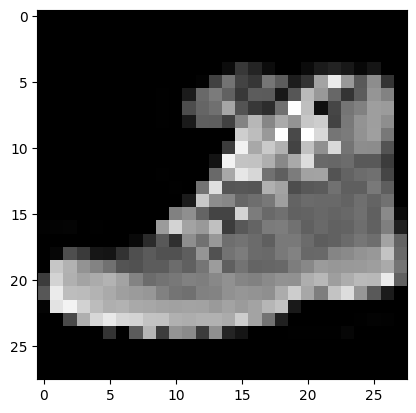

In [19]:
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(train_x[390])

### matrix and tensor

In [20]:
train_x = [[[pixel/255.0 for pixel in row] for row in img] for img in train_x]

In [21]:
img = train_x[0]
img[20][15]

0.7647058823529411

In [22]:
class Matrix:
  def __init__(self, xs): self.xs = xs
  def __getitem__(self, idxs): return self.xs[idxs[0]][idxs[1]]

In [23]:
m = Matrix(img)
m[20,15]

0.7647058823529411

In [24]:
import torch

In [25]:
from torch import tensor

In [26]:
tensor([1., 2., 3.])

tensor([1., 2., 3.])

In [27]:
tens = tensor(img)
tens[20,15]

tensor(0.7647)

In [28]:
x_train, y_train = map(tensor, (train_x, train_y))

In [29]:
x_train.shape, y_train.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [30]:
x_train.type()

'torch.FloatTensor'

### random number generator from scratch

In [31]:
# based on the wichmann hill algorithm
rnd_state = None
def seed(a):
  global rnd_state
  a, x = divmod(a, 30268)
  a, y = divmod(a, 30306)
  a, z = divmod(a, 30322)
  rnd_state = int(x)+1, int(y)+1, int(z)+1

In [32]:
seed(42)

In [33]:
def rand():
    global rnd_state
    x, y, z = rnd_state
    x = (171 * x) % 30269
    y = (172 * y) % 30307
    z = (170 * z) % 30323
    rnd_state = x,y,z
    return (x/30269 + y/30307 + z/30323) % 1.0

In [34]:
rand()

0.25420336316883324

In [35]:
seed(42)
rand()

0.25420336316883324

In [36]:

if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)


In parent: 0.46884405296716114
In child: 0.46884405296716114


In [37]:
if os.fork(): print(f"in parent: {torch.rand(1)}")
else:
  print(f"in child: {torch.rand(1)}")
  os._exit(os.EX_OK)

in parent: tensor([0.9596])
in child: tensor([0.9596])


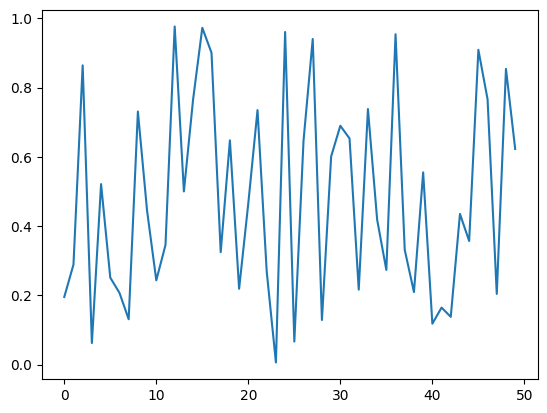

In [38]:
plt.plot([rand() for _ in range(50)])

(array([1000.,  986., 1057., 1033.,  953., 1004., 1031.,  975., 1007.,
         954.]),
 array([1.44098502e-04, 1.00125624e-01, 2.00107150e-01, 3.00088676e-01,
        4.00070202e-01, 5.00051728e-01, 6.00033254e-01, 7.00014780e-01,
        7.99996306e-01, 8.99977832e-01, 9.99959358e-01]),
 <BarContainer object of 10 artists>)

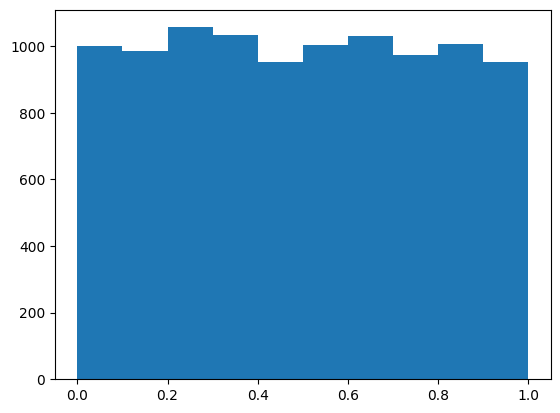

In [39]:
plt.hist([rand() for _ in range(10000)])

In [40]:
%timeit -n 10 list(chunk([rand() for _ in range(7840)], 10))

4.35 ms ± 371 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%timeit -n 10 torch.randn(784,10)

The slowest run took 5.85 times longer than the fastest. This could mean that an intermediate result is being cached.
119 µs ± 99 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Matrix Multiplication

In [42]:
x_train = x_train.view(60000, -1)
x_train.shape

torch.Size([60000, 784])

In [43]:
weights = torch.randn(784, 10)
bias = torch.randn(10)

In [44]:
m1 = x_train[:5]
m2 = weights
# m1 = torch.tensor([[1,2], [3, 4], [5, 6]])
# m2 = torch.tensor([[7, 9, 11], [8, 10, 12]])

In [45]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [46]:
ar, ac = m1.shape
br, bc = m2.shape
(ar, ac), (br, bc)

((5, 784), (784, 10))

In [47]:
res = torch.zeros(ar, bc)

In [48]:
for i in range(ar):
  for k in range(ac):
    for j in range(bc):
      res[i,j] += (m1[i,k] * m2[k,j])

In [49]:
res, res.shape

(tensor([[ 1.1530e+01,  2.3420e+01, -1.8425e+01, -2.3015e+01,  7.4059e+00,
           1.4997e+01,  2.9726e+00, -1.1810e+00,  2.9914e+00, -1.8528e+00],
         [ 1.9191e+01,  2.6150e+01, -9.4763e+00, -8.6394e-01,  4.3896e+00,
           2.1563e+01,  1.0014e+01,  1.0784e+01, -3.8496e+00, -1.3220e+01],
         [ 2.5757e+00,  3.8298e+00, -4.5285e+00,  1.4742e+00, -3.5365e-01,
           1.1591e+01,  1.2838e-01,  1.7775e+00,  6.4072e+00, -5.5506e+00],
         [ 4.7746e+00,  2.1229e+01, -4.8243e+00, -5.2080e-03, -5.6599e+00,
           1.3742e+01,  9.7805e+00,  1.8285e+00, -5.8912e-01, -6.1215e+00],
         [ 7.1116e+00,  2.0857e+01, -2.3477e+00, -6.8644e+00,  1.0960e+01,
           2.2883e+01,  1.4269e+01,  1.9131e+00,  6.8462e+00, -1.9587e+01]]),
 torch.Size([5, 10]))

In [102]:
def matmul(a, b):
  ar, ac = a.shape
  br, bc = b.shape
  res = torch.zeros(ar, bc)
  for i in range(ar):
    for k in range(ac):
      for j in range(bc):
        res[i,j] += (m1[i,k] * m2[k,j])
  return res

In [103]:
t1 = matmul(m1, m2)

In [104]:
t1

tensor([[ 1.1530e+01,  2.3420e+01, -1.8425e+01, -2.3015e+01,  7.4059e+00,
          1.4997e+01,  2.9726e+00, -1.1810e+00,  2.9914e+00, -1.8528e+00],
        [ 1.9191e+01,  2.6150e+01, -9.4763e+00, -8.6394e-01,  4.3896e+00,
          2.1563e+01,  1.0014e+01,  1.0784e+01, -3.8496e+00, -1.3220e+01],
        [ 2.5757e+00,  3.8298e+00, -4.5285e+00,  1.4742e+00, -3.5365e-01,
          1.1591e+01,  1.2838e-01,  1.7775e+00,  6.4072e+00, -5.5506e+00],
        [ 4.7746e+00,  2.1229e+01, -4.8243e+00, -5.2080e-03, -5.6599e+00,
          1.3742e+01,  9.7805e+00,  1.8285e+00, -5.8912e-01, -6.1215e+00],
        [ 7.1116e+00,  2.0857e+01, -2.3477e+00, -6.8644e+00,  1.0960e+01,
          2.2883e+01,  1.4269e+01,  1.9131e+00,  6.8462e+00, -1.9587e+01]])

In [53]:
%time _= matmul(m1, m2)

CPU times: user 1.04 s, sys: 5.16 ms, total: 1.05 s
Wall time: 1.06 s


## Numba

In [54]:
from numba import njit
import numpy as np

In [55]:
@njit
def dot(a, b):
  res = 0
  for i in range(len(a)): res += a[i] * b[i]
  return res

In [56]:
%time dot(np.array([1., 2., 3.]), np.array([2., 3., 4.]))

CPU times: user 1.31 s, sys: 102 ms, total: 1.41 s
Wall time: 1.59 s


20.0

In [57]:
%time dot(np.array([1., 2., 3.]), np.array([2., 3., 4.]))

CPU times: user 34 µs, sys: 2 µs, total: 36 µs
Wall time: 41.5 µs


20.0

In [58]:
%time dot(np.array([10., 20., 30., 50.]), np.array([20., 30., 40., 50.]))

CPU times: user 36 µs, sys: 3 µs, total: 39 µs
Wall time: 44.8 µs


4500.0

In [59]:
def matmul(a, b):
  ar, ac = a.shape
  br, bc = b.shape
  res = torch.zeros(ar, bc)
  for i in range(ar):
    for j in range(bc):
      res[i,j] += dot(a[i, :], b[:, j])
  return res

In [60]:
m1a, m2a = np.array(m1), np.array(m2)

In [61]:
from fastcore.test import *

In [62]:
test_close(t1, matmul(m1a, m2a))

In [63]:
%timeit -n 50 matmul(m1a, m2a)

1.23 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


## Elementwise Ops

In [64]:
a = torch.tensor([1., 2., 3.])
b = torch.tensor([10., -20., 30.])

In [65]:
a+b

tensor([ 11., -18.,  33.])

In [66]:
(a<b).float().mean()

tensor(0.6667)

In [67]:
a * a

tensor([1., 4., 9.])

In [68]:
frobenius_norm = (a * a).sum().sqrt()

In [69]:
frobenius_norm

tensor(3.7417)

In [70]:
def matmul(a, b):
  ar, ac = a.shape
  br, bc = b.shape
  res = torch.zeros(ar, bc)
  for i in range(ar):
    for j in range(bc):
      res[i,j] = (a[i,:] * b[:,j]).sum()
  return res

In [71]:
test_close(t1, matmul(m1, m2))

In [72]:
%timeit -n 50 matmul(m1,m2)

1.8 ms ± 231 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [73]:
def matmul(a, b):
  ar, ac = a.shape
  br, bc = b.shape
  res = torch.zeros(ar, bc)
  for i in range(ar):
    for j in range(bc):
      res[i,j] = torch.dot(a[i,:], b[:,j])
  return res

In [74]:
test_close(t1, matmul(m1, m2), eps=1e-3)

In [75]:
%timeit -n 50 matmul(m1,m2)

1.25 ms ± 83.9 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [76]:
m = torch.tensor([[1., 2., 3.], [4., 5., 6.], [7., 8., 9.]])
t = torch.tensor([10., 20., 30.])

In [77]:
m.shape, t.shape

(torch.Size([3, 3]), torch.Size([3]))

In [78]:
c = m+t; c.shape

torch.Size([3, 3])

In [79]:
c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [86]:
d = torch.tensor([[34., 56., 78.]])
d.shape

torch.Size([1, 3])

In [87]:
t.expand_as(m)

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [88]:
t

tensor([10., 20., 30.])

In [105]:
t.expand_as(d).shape, t.shape

(torch.Size([1, 3]), torch.Size([3]))

In [106]:
t, t.shape

(tensor([10., 20., 30.]), torch.Size([3]))

In [108]:
t10 = t[None, :]; t20 = t[:, None]

In [109]:
t10.shape, t20.shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [110]:
t10

tensor([[10., 20., 30.]])

In [111]:
t20

tensor([[10.],
        [20.],
        [30.]])

In [112]:
t30 = t10*t20; t30

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [113]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [124]:
def matmul(a, b):
  # a, b = map(tensor, (a, b))
  res = a[:, :, None] * b[None]
  return res.sum(dim=1)

In [127]:
test_close(t1, matmul(m1, m2), eps=1e-3)
# broadcast_mul = matmul(m1, m2)
# broadcast_mul.shape

In [128]:
%timeit -n 50 matmul(m1, m2)

78.7 µs ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [129]:
%time _=matmul(x_train, weights)

CPU times: user 1.28 s, sys: 2.38 s, total: 3.66 s
Wall time: 4.02 s
